# Predict Personality
This notebook is a poc of how we can predict personality trades based on raw text i.e. an application or the history of ones tweets.

In order to acheive this we will use:
* pre-trained word embedding 
* Personality test questionaire
* LSTM to predict personaity trade
* Semantics dictionary
* LSTM to predict possitive or negatie

The idea is to predict the personality trade mach for each sentence and then predict the semantic orientation in order to apply the score as possitive or negative.

We start with the Big5 personalities test: https://ipip.ori.org/newBigFive5broadTable.htm and use data from: http://openpsychometrics.org.

## Download data big5

In [ ]:
import wget
import os

data_folder = './data'
os.makedirs(data_folder, exist_ok=True)

url = 'http://openpsychometrics.org/_rawdata/BIG5.zip'
file = './data/big5.zip'
wget.download(url, file)

## Big5 codebook

In [1]:
# Print codebook
file = './data/big5/codebook.txt'
with open(file) as fp:
    cnt = 0
    lines = list()
    for line in fp:
        print("{}".format(line))
        cnt += 1
        lines.append(line)

This data was collected (c. 2012) through on interactive online personality test. Participants were informed that their responses would be recorded and used for research at the begining of the test and asked to confirm their consent at the end of the test.



The following items were rated on a five point scale where 1=Disagree, 3=Neutral, 5=Agree (0=missed). All were presented on one page in the order E1, N2, A1, C1, O1, E2...... 



E1	I am the life of the party.

E2	I don't talk a lot.

E3	I feel comfortable around people.

E4	I keep in the background.

E5	I start conversations.

E6	I have little to say.

E7	I talk to a lot of different people at parties.

E8	I don't like to draw attention to myself.

E9	I don't mind being the center of attention.

E10	I am quiet around strangers.

N1	I get stressed out easily.

N2	I am relaxed most of the time.

N3	I worry about things.

N4	I seldom feel blue.

N5	I am easily disturbed.

N6	I get upset easily.

N7	I change my mood a lot.

N8	I have

## Extract questionaire sentences

In [2]:
import random
lines = lines[4:54]

cnt = 0
for line in lines:
    split_line = line.split("\t")
    split_line = [s.strip("\n") for s in split_line]
    lines[cnt] = split_line
    cnt += 1

In [3]:
random.shuffle(lines)

In [4]:
lines[0:5]

[['N8', 'I have frequent mood swings.'],
 ['A7', 'I am not really interested in others.'],
 ['E5', 'I start conversations.'],
 ['E10', 'I am quiet around strangers.'],
 ['O7', 'I am quick to understand things.']]

## Create scoring for the questionare
Go To https://ipip.ori.org/newBigFive5broadTable.htm
Based on this, we can se that a statemnet either contributes positively or negatively to a personality trade score.

In [ ]:
score = [1, -1, 1, -1, 1, -1, 1, -1, 1, -1,
        -1, 1, -1, 1, -1, -1, -1, -1, -1, -1,
        -1, 1, -1, 1, -1, 1, -1, 1, 1, 1,
        1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 
        1, -1, 1, -1, 1, -1, 1, 1, 1, 1]

# Embed lines
Download pretrained embedding. Then initialize a gensim word2vec with those weghts in order to fine tune the embedding for the questionaire.

In [ ]:
import wget
#url = 'https://loar.kb.dk/bitstream/handle/1902/329/danish_newspapers_1880To2013.txt?sequence=4&isAllowed=y'
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
file = 'glove.6B.300d.zip'
wget.download(url, file) 

## Initialize word2vec
https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights 

In [5]:
sentences= list()
for sentence in lines:
    sentences.append(sentence[1].split())
sentences[0:5]

[['I', 'have', 'frequent', 'mood', 'swings.'],
 ['I', 'am', 'not', 'really', 'interested', 'in', 'others.'],
 ['I', 'start', 'conversations.'],
 ['I', 'am', 'quiet', 'around', 'strangers.'],
 ['I', 'am', 'quick', 'to', 'understand', 'things.']]

C:\Anaconda\envs\azureML\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Anaconda\envs\azureML\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


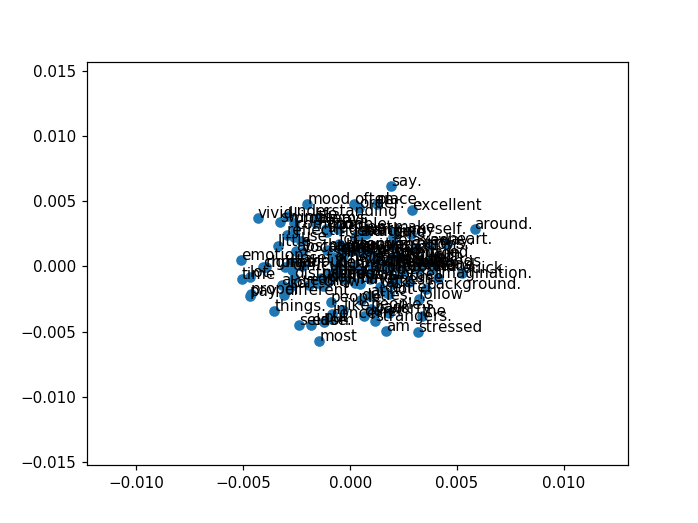

In [6]:
%matplotlib notebook
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

# train model
model_1 = Word2Vec(sentences, size=300, min_count=1)

# fit a 2d PCA model to the vectors
X = model_1[model_1.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model_1.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [8]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
tmp_file = get_tmpfile("test_word2vec.txt")
glove_file = "data\glove.6B.300d\glove.6B.300d.txt"

In [9]:
# Lodd weights
model = KeyedVectors.load_word2vec_format(tmp_file)

In [10]:
#Train on senences with weights initialized from glove
model_2 = Word2Vec(size=300, min_count=1)
model_2.build_vocab(sentences)
total_examples = model_2.corpus_count
model_2.build_vocab([list(model.vocab.keys())], update=True)
model_2.intersect_word2vec_format(tmp_file, binary=False, lockf=1.0)
model_2.train(sentences, total_examples=total_examples, epochs=model_2.iter)

C:\Anaconda\envs\azureML\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


(1032, 1360)

C:\Anaconda\envs\azureML\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


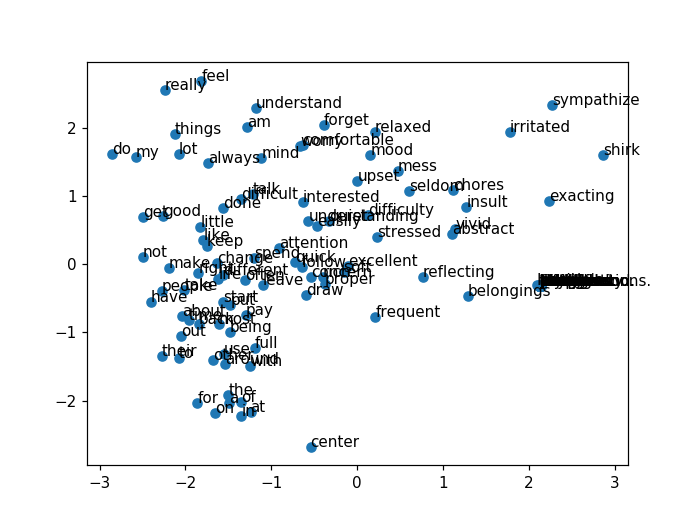

In [11]:
%matplotlib notebook
# fit a 2d PCA model to the vectors
X = model_2[model_1.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model_1.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

# Predict personality trade

In [12]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


In [13]:
# Word2index and back
word = "whatever"  # for any word in model
i = model_2.wv.vocab[word].index
model_2.wv.index2word[i] == word

True

In [14]:
def sentences_to_indices(sentences, gensim_model, max_len):
    m = len(sentences)                 
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                       
        sentence_words = sentences[i]
        j = 0
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = gensim_model.wv.vocab[sentence_words[j]].index
            # Increment j to j + 1
            j = j + 1
            
    ### END CODE HERE ###
    
    return X_indices

In [15]:
def pretrained_embedding_layer(gensim_model):
    """
    Creates a Keras Embedding() layer and loads in pre-trained Gensim 300 d vector.
    """
    
    vocab_len = len(gensim_model.wv.vocab)
    emb_dim = gensim_model.wv["I"].shape[0]
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for index in range(vocab_len):
        emb_matrix[index, :] = gensim_model.wv[gensim_model.wv.index2word[index]]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [16]:
#test
embedding_layer = pretrained_embedding_layer(model_2)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

Instructions for updating:
Colocations handled automatically by placer.
weights[0][1][3] = -0.45223102


In [17]:
def predict_big5(input_shape, gensim_model):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = "int32")
    
    embedding_layer = pretrained_embedding_layer(gensim_model)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.2)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.2)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(activation='softmax', units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [18]:
model = predict_big5((12,), model_2)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 12, 300)           120011700 
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 128)           219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
___________________________

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
X_train_indices = sentences_to_indices(sentences, model_2, 12)

In [21]:
list(map(lambda x : model_2.wv.index2word[int(x)], X_train_indices[40]))

['I', 'shirk', 'my', 'duties.', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I']

In [22]:
#One hot encode target
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
data = list(map(lambda x: x[0][0], lines))
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)


['N' 'A' 'E' 'E' 'O' 'C' 'O' 'C' 'C' 'N' 'O' 'A' 'N' 'N' 'N' 'E' 'E' 'C'
 'N' 'N' 'A' 'C' 'A' 'O' 'E' 'A' 'C' 'N' 'E' 'E' 'C' 'O' 'E' 'E' 'A' 'A'
 'O' 'C' 'E' 'A' 'C' 'O' 'O' 'A' 'O' 'C' 'N' 'O' 'N' 'A']
[3 0 2 2 4 1 4 1 1 3 4 0 3 3 3 2 2 1 3 3 0 1 0 4 2 0 1 3 2 2 1 4 2 2 0 0 4
 1 2 0 1 4 4 0 4 1 3 4 3 0]
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1

C:\Anaconda\envs\azureML\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [23]:
Y_train_oh = onehot_encoded

In [24]:
model.fit(X_train_indices, Y_train_oh, epochs = 30, batch_size = 10, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
50/50 [==============================] - 3s 55ms/step - loss: 1.6095 - acc: 0.2000
Epoch 2/30
50/50 [==============================] - 1s 13ms/step - loss: 1.5948 - acc: 0.4000
Epoch 3/30
50/50 [==============================] - 1s 13ms/step - loss: 1.5650 - acc: 0.4200
Epoch 4/30
50/50 [==============================] - 1s 18ms/step - loss: 1.4997 - acc: 0.4800
Epoch 5/30
50/50 [==============================] - 1s 14ms/step - loss: 1.4129 - acc: 0.5400
Epoch 6/30
50/50 [==============================] - 0s 10ms/step - loss: 1.3137 - acc: 0.6800
Epoch 7/30
50/50 [==============================] - 1s 18ms/step - loss: 1.2334 - acc: 0.7000
Epoch 8/30
50/50 [==============================] - 0s 9ms/step - loss: 1.1583 - acc: 0.7600
Epoch 9/30
50/50 [==============================] - 1s 19ms/step - loss: 1.1524 - acc: 0.7600
Epoch 10/30
50/50 [==============================] - 1s 13ms/step - loss: 1.0700 - acc: 0.8400
Epoch 11/30


In [42]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = [['I','shirk','duties']]
X_test_indices = sentences_to_indices(x_test, model_2, 12)

In [43]:
print(model.predict(X_test_indices))

[[0.14891627 0.40435687 0.14891772 0.14891694 0.14889227]]


In [44]:
print(label_encoder.inverse_transform([np.argmax(model.predict(X_test_indices))]))

['C']


# Predict positive vs negative